In [1]:

import os
os.chdir('/home/BCCRC.CA/ssubedi/projects/experiments/asapp')
from asap.util.io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
from asap.util import topics

import matplotlib.pylab as plt
import seaborn as sns
import colorcet as cc

from asap.data.dataloader import DataSet
from scipy.linalg import qr

experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

sample_in = args.home + args.experiment + args.input+ args.sample_id +'/'+args.sample_id
sample_out = args.home + args.experiment + args.output+ args.sample_id +'/'+args.sample_id

dl = DataSet('pbmc',sample_in,sample_out)
dl.initialize_data()

print(dl.inpath)
print(dl.outpath)

dl.load_data()




/home/BCCRC.CA/ssubedi/projects/experiments/asapp/data/pbmc/pbmc
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/pbmc/pbmc


In [2]:
import anndata
import scanpy as sc

adata = anndata.AnnData(dl.mtx.T)
dfvars = pd.DataFrame(dl.genes)
dfobs = pd.DataFrame(dl.barcodes)
adata.obs = dfobs
adata.var = dfvars

sc.pp.filter_cells(adata, min_genes=0)
sc.pp.filter_genes(adata, min_cells=0)
adata.var['mt'] = adata.var_names.str.startswith('MT-')  
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

sc.pp.normalize_total(adata, target_sum=10000)

sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]

sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

sc.tl.pca(adata, svd_solver='arpack')

/home/BCCRC.CA/ssubedi/.conda/envs/ssubedi/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/BCCRC.CA/ssubedi/.conda/envs/ssubedi/lib/python3.9/site-packages/anndata/_core/anndata.py:1236: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.var` of view, copying.
... storing 0 as categorical


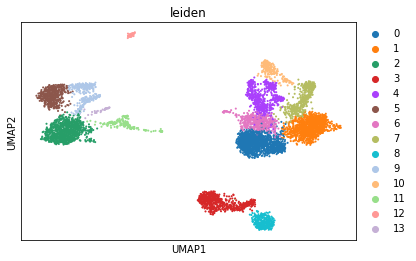

In [3]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden'])

... storing 'batch' as categorical


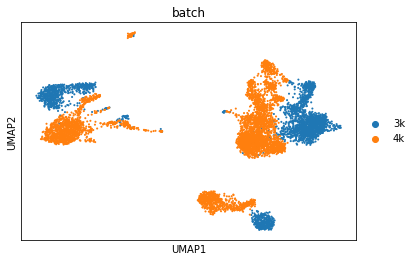

In [4]:
adata.obs['batch']= [x.split('_')[1] for x in dl.barcodes]
sc.pl.umap(adata, color=['batch'])

In [5]:
adata_combat = anndata.AnnData(dl.mtx.T)
dfvars = pd.DataFrame(dl.genes)
dfobs = pd.DataFrame(dl.barcodes)
adata_combat.obs = dfobs
adata_combat.var = dfvars
adata_combat.obs['celltype']=dl.batch_label

In [6]:
sc.pp.normalize_total(adata_combat, target_sum=10000)

sc.pp.log1p(adata_combat)
sc.pp.combat(adata_combat, key='celltype')

... storing 'celltype' as categorical
... storing 0 as categorical


Found 15237 genes with zero variance.


/home/BCCRC.CA/ssubedi/.conda/envs/ssubedi/lib/python3.9/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: invalid value encountered in true_divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()
/home/BCCRC.CA/ssubedi/.conda/envs/ssubedi/lib/python3.9/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in true_divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


In [7]:
sc.pp.highly_variable_genes(adata_combat)
sc.pp.pca(adata_combat, n_comps=30, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata_combat)
sc.tl.umap(adata_combat)

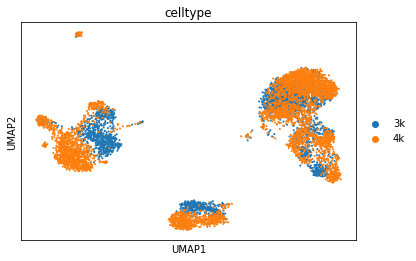

In [8]:
sc.pl.umap(adata_combat, color=['celltype'])

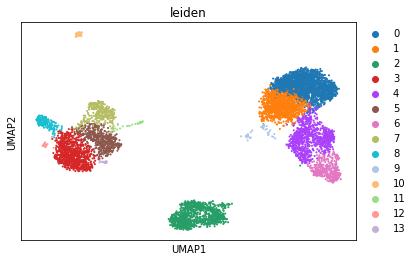

In [12]:
# sc.tl.leiden(adata_combat)
sc.pl.umap(adata_combat, color=['leiden'])

In [14]:
df_leiden = pd.DataFrame(adata_combat.obs['leiden'])
df_leiden['cell'] = dl.barcodes
df_leiden

,leiden,cell
0,0,AAACATACAACCAC-1_3k
1,2,AAACATTGAGCTAC-1_3k
2,1,AAACATTGATCAGC-1_3k
3,5,AAACCGTGCTTCCG-1_3k
4,6,AAACCGTGTATGCG-1_3k
...,...,...
7035,3,TTTGGTTTCGCTAGCG-1_4k
7036,6,TTTGTCACACTTAACG-1_4k
7037,6,TTTGTCACAGGTCCAC-1_4k
7038,2,TTTGTCAGTTAAGACA-1_4k


In [15]:
df_leiden.to_csv(sample_out+'_scanpy.csv.gz',index=False,compression='gzip')

In [10]:
adata_combat

AnnData object with n_obs × n_vars = 7040 × 36511
    obs: 0, 'celltype'
    var: 0, 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
### run pca here -->



Q = (np.sign(Q) + 1)/2

df = pd.DataFrame(Q,dtype=int)
df['code'] = df.astype(str).agg(''.join, axis=1)
df = df.reset_index()
df = df[['index','code']]
pbulkd = df.groupby('code').agg(lambda x: list(x)).reset_index().set_index('code').to_dict()['index']

pbulk = {}
for key, value in pbulkd.items():
    pbulk[key] = mtx[:,value].sum(1)

pd.DataFrame.from_dict(pbulk,orient='index')


from asap.annotation import ASAPNMF
asap = ASAPNMF(adata=dl)
asap.get_pbulk()

In [2]:
nz_cutoff = 10
dfall = dfall[dfall.iloc[:,2:].sum(1)>nz_cutoff].reset_index(drop=True)
genes = dfall['gene'].values
glens = dfall['length'].values
dfall = dfall.drop(columns=['gene','length'])


qt = QuantileTransformer(random_state=0)
dfall_q = qt.fit_transform(dfall)

mu_total = np.mean(dfall_q,axis=1)
 
scaler = StandardScaler()
dfall_q = pd.DataFrame(scaler.fit_transform(dfall_q.T).T,columns=dfall.columns)


u,d,v = skrsvd(dfall_q.to_numpy()/np.sqrt(dfall_q.shape[1]),n_components=50,random_state=0)
L_total = u * d

In [3]:
def get_sc(L_total,mu_total,dfct,L_ct,mu_ct,pve_ct):
    z_total = np.dot(L_total,np.random.normal(size=L_total.shape[1])) + mu_total
    z_ct = np.dot(L_ct,np.random.normal(size=L_ct.shape[1])) + mu_ct
    x_sample = np.sort(dfct.apply(lambda x: np.random.choice(x), axis=1))
    z_sample = np.array([np.nan] * len(x_sample))
    z = z_ct * np.sqrt(pve_ct) + z_total * np.sqrt(1 - pve_ct)
    z_sample[np.argsort(z)] = x_sample
    return z_sample


In [4]:
ct_prop = {'NK':7.4,
 'THSTAR':2.1,
 'TH1':1.5,
 'B_CELL_NAIVE':5.2,
 'TREG_MEM':1.2,
 'TH2':1.9,
 'TREG_NAIVE':0.4,
 'MONOCYTES':17.7,
 'M2':1.6,
 'TFH':2.7,
 'CD8_NAIVE':6.4,
 'CD4_NAIVE':11,
 'TH17':3.2
}

In [ ]:
size= 2
pve_ct = 0.99
all_indx = []
dfsc = pd.DataFrame()
for ct in cts:
    dfct = dfall[[x for x in dfall.columns if ct in x]]
    dfct_q = dfall_q[[x for x in dfall_q.columns if ct in x]]

    mu_ct = dfct_q.mean(1)

    scaler = StandardScaler()
    dfct_q = pd.DataFrame(scaler.fit_transform(dfct_q.T).T)

    u,d,v = rsvd(dfct_q.to_numpy()/np.sqrt(dfct_q.shape[1]),n_components=50,random_state=0)
    L_ct = u * d

    ct_sc = []
    for i in range(size):
        ct_sc.append(get_sc(L_total,mu_total,dfct,L_ct,mu_ct,pve_ct))
    df_ctsc = pd.DataFrame(ct_sc,columns=genes)

    dfsc = pd.concat([dfsc,df_ctsc],axis=0,ignore_index=True)
    all_indx.append([ str(i) + '_' + ct.replace(' ','') for i in range(size)])

    print(ct)

In [ ]:
dfsc.index = np.array(all_indx).flatten()
dfsc

In [ ]:
# sns.scatterplot(x=np.log(dfsc.loc['0_NK']),y=np.log(dfsc.loc['1_NK']),s=2)
sns.scatterplot(x=np.log(dfsc.loc['1_NK']),y=np.log(dfsc.loc['0_M2']),s=2)